# HIV Modeling
By: Michael Remley

In [174]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


from matplotlib.pyplot import twinx

Here's a make_system function to set up our initial state object, figure out our time step for interval t_step minutes, and adjust our parameters so they calculate right in the time steps. τ and ρ are the ones <strong> without </strong> a change to their value.

In [175]:
def make_system(params,t_0,t_end,t_step):
    """Make a system object for the RLEV model.
    
    params(Γ,μ,τ,β,ρ,α,σ,δ,π): see Table in paper
    t_0: Beginning time in days
    t_end: Ending time in days
    
    returns: System object
    Note: t_end is not in days
    """
    # Start with a number of active, uninfected cells and virons, but no infected cells of any kind
    init = State(R=200,L=0,E=0,V=4e-7)
    
    #Get our parameters
    Γ,μ,τ,β,ρ,α,σ,δ,π = params
    
    # Modify time-dependent parameters
    t_factor = 1440 / t_step
    t_end = t_end * t_factor
    
    t0 = t_0
    

    return System(Γ=Γ/ t_factor,
                  μ=μ/ t_factor,
                  τ=τ,
                  β=β/ t_factor,
                  ρ=ρ, 
                  α=α/ t_factor, 
                  σ=σ/ t_factor, 
                  δ=δ/ t_factor, 
                  π=π/ t_factor, 
                  t0=t0, t_end=t_end,t_step=1/t_factor,init=init)

This is the update function that uses the differential equations described in the research paper as difference equations for a given time step. The first step is to calculate the flows and the second is to apply them to our stocks. It is important for these to be calculated then applied so each instance of r, l , e, and v is from the right row.

In [176]:
def update_func(state,t,system):
    """Update the RLEV model.
    
    state: State (R,L,E,V)
    t: time
    system: System object
    
    returns: State (sir)
    """
    r,l,e,v = state
    #Γ,μ,τ,β,ρ,α,σ,δ,π,t_0,t_end,init = system
    unpack(system)
    
    # Flow equations from the article
    ΔR = Γ*τ - μ*r - β*r*v
    ΔL = ρ*β*r*v - μ*l - α*l
    ΔE = (1.0 - ρ)*β*r*v + α*l - δ*e
    ΔV = π*e - σ*v
    
    # Calculate stock changes
    r += ΔR
    l += ΔL
    e += ΔE
    v += ΔV
    
    return State(R=r, L=l, E=e, V=v)



This is a standard run_simulation function except for the addition of frame.index being divided to give days. It only uses the value for an 80 minute time step, hard coded.

In [177]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    frame = TimeFrame(columns=system.init.index)
    frame.row[t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    frame.index *= t_step
    return frame

In [178]:
def plot_results(results):
    # Calculate total CD4 Lymphocytes
    totalCD4s = TimeSeries()
    totalCD4s = 1000*(1-0.2)+results.R + results.L + results.E 
    
    activecells = results.R + results.E + results.L

    f2, (ax3, ax4, ax5) = plt.subplots(3, 1,figsize = (15,15),sharex=True)

    ax3.plot(results.R/totalCD4s,label="Activated, healthy cells [R]")
    ax3.plot(results.E/totalCD4s,label="Actively infected cells [E]")
    ax3.plot(results.L/totalCD4s,"--",label="Latently infected cells [L]")
    ax3.set_ylabel("Percentage of CD4 Lymphocytes")
    ax3.legend()
    ax3.grid()

    ax4.plot(results.V,label="Free Virons [V]")
    ax4.set_ylabel("Virons [V]")
    ax4.grid()

    ax5.plot(totalCD4s,label="Total CD4 Lymphocytes")
    ax5.grid()

With the functions squared away, we can get our parameters, make a system, and run the simulation. The units in the original article are not very descriptive, so I added a little more detail here.

In [179]:
params = Params(Γ = 1.36,    # CD4-cells / day
                μ = 1.36e-3, # 1 / day   
                τ = 0.2,     # R-cells / CD4-cells   
                β = 0.00027, # 1 / (Virons*day)   
                ρ = 0.1,     # L-cells / R-cells   
                α = 3.6e-2,  # Cells / L-cells
                σ = 2,       # 1 / (Virons * day) (t1/2 = 0.5 day)
                δ = 1/3,    # 1 / day (t1/2 = 3 days)
                π = 100      # Virons / (E-cells * day)
               )
# Make a system to run for 120 days with 80 minute time steps
system = make_system(params,0,120,80)
results = run_simulation(system, update_func);


The first two lines here calculate the total number of CD4 lymphocytes. The rest of the mess is just to make graphs that look exactly like the ones in the article.

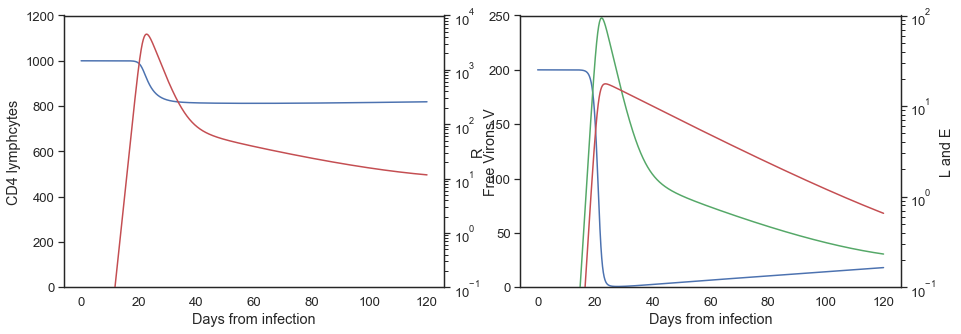

In [180]:

# Calculate total CD4 Lymphocytes
totalCD4s = TimeSeries()
totalCD4s = 1000*(1-0.2)+results.R + results.L + results.E 

# Set up our figure and subplots
f, (ax1a, ax2a) = plt.subplots(1, 2,figsize = (15,5))

# Plot total CD4s on left y-axis
ax1a.plot(totalCD4s)
ax1a.set_ybound(0,1200)
ax1a.set_ylabel("CD4 lymphcytes")

# Plot Virons on right y-axis
ax1b = twinx(ax1a)
ax1b.plot(results.V, "r")
ax1b.set_yscale("log")
ax1b.set_ybound(0.1,1e4)
ax1b.set_ylabel("Free Virons V")

# Plot R-cells on left y-axis
ax2a.plot(results.R)
ax2a.set_ylabel("R")
ax2a.set_ybound(0,250)

# Plot E and L cells on right y-axis
ax2b = twinx(ax2a)
ax2b.plot(results.E,"g")
ax2b.plot(results.L,"r")

ax2b.set_ylabel("L and E")
ax2b.set_yscale("log")
ax2b.set_ybound(0.1,100)
ax2b.set_xlabel("Days from Infection")

ax1a.set_xlabel("Days from infection")
ax2a.set_xlabel("Days from infection");

Shown above, these graphs match the article exactly! Either I did everything right or the mistakes all cancelled out. I and others I talked to did not love the format, so I created something new below.

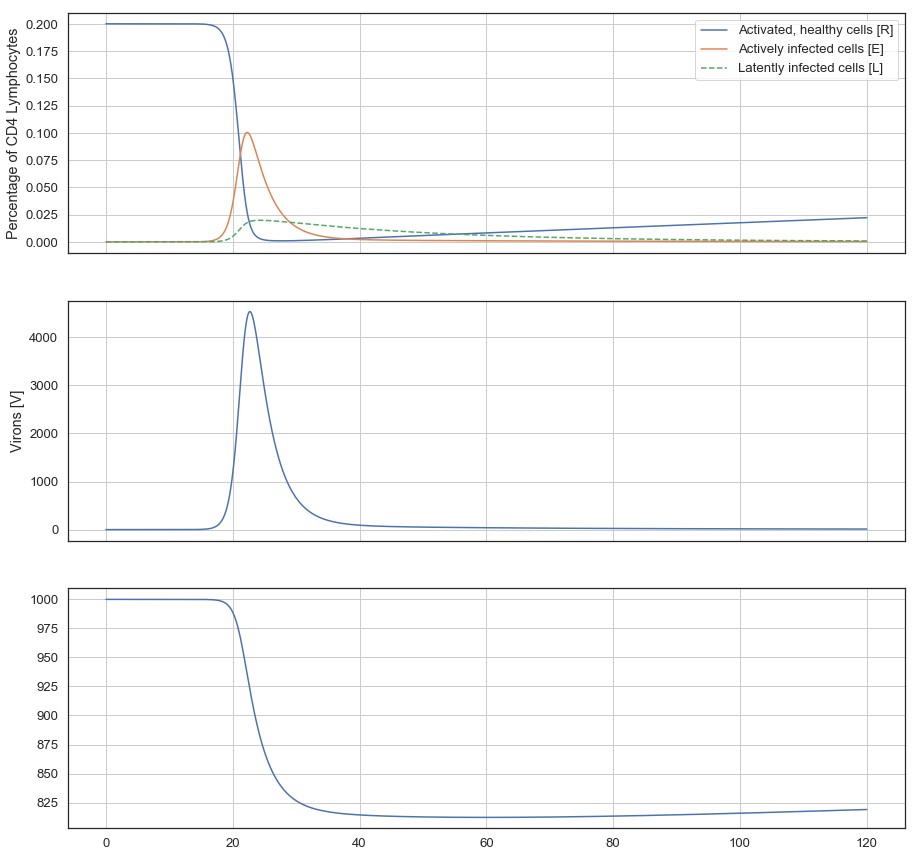

In [181]:
plot_results(results)

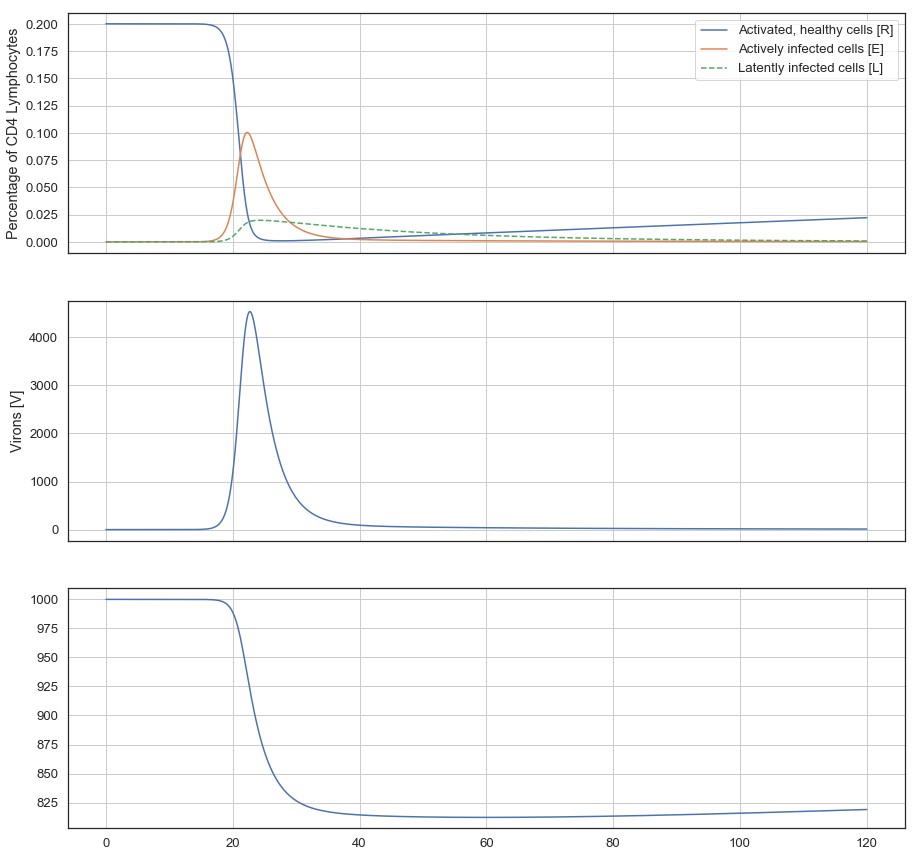

In [182]:
params = Params(Γ = 1.36,    # CD4-cells / day
                μ = 1.36e-3, # 1 / day   
                τ = 0.2,     # R-cells / CD4-cells   
                β = 0.00027, # 1 / (Virons*day)   
                ρ = 0.1,     # L-cells / R-cells   
                α = 3.6e-2,  # Cells / L-cells
                σ = 2,       # 1 / (Virons * day) (t1/2 = 0.5 day)
                δ = 1/3,    # 1 / day (t1/2 = 3 days)
                π = 100      # Virons / (E-cells * day)
               )
# Make a system to run for 120 days with 80 minute time steps
system = make_system(params,0,120,80)
results = run_simulation(system, update_func);
plot_results(results)